In [ ]:
!nvidia-smi

Wed Aug  4 14:47:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install effdet
# !pip install timm
# !pip install python-gdcm
!pip install wandb==0.10.33
!pip install albumentations==1.0.3

# check bounding box coordinate

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 170 kB 66.2 MB/s 
     |████████████████████████████████| 133 kB 58.9 MB/s 
     |████████████████████████████████| 97 kB 9.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=c4bc154790d60fa60d06f333c0348fe4f753938c33b0ffaecf98582badad5c99
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ab6eaf55955759092c883f00cabbbcbe7c65a58ff1cb4f3b20dcddd17c46411f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
     |████████████████████████████████| 98 kB 4.4 MB/s 
     |████████████████████████████████| 37.1 MB 1.3 MB/s 
  Attempting uninstall: album

# Library

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import random
from collections import Counter, defaultdict
from itertools import chain

import ast
import cv2
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_to_albumentations, convert_bbox_from_albumentations

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset, random_split
# from torch.cuda.amp import GradScaler, autocast

import wandb

import torchvision

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

# from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import matplotlib

import os
import warnings
from datetime import datetime, timedelta
import time
import gc
import re
import yaml
import shutil
from tqdm.notebook import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
# from torchinfo import summary

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 25)
pd.set_option('display.max_rows', 20)
# %load_ext line_profiler

In [ ]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla P100-PCIE-16GB


In [ ]:
prepare_data = True
if os.path.exists('/content/data'):
    prepare_data = False

In [ ]:
if prepare_data:    
    from google.colab import files, drive

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
    
    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    # !mkdir data && cd data && mkdir images && cd images && kaggle datasets download -d xhlulu/siim-covid19-resized-to-512px-png
    # !unzip /content/data/images/siim-covid19-resized-to-512px-png.zip -d /content/data/images
    !mkdir data && cd data && mkdir images && cd images && kaggle datasets download sunpnwt12/siim-covid19-train
    !unzip /content/data/images/siim-covid19-train.zip -d /content/data/images
    !git clone https://github.com/ultralytics/yolov5.git
    !mv /content/data/images/siim-covid19-train/meta.csv /content/data

    drive.mount('/content/drive')
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_df.csv /content/data/train_df.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_image_level.csv /content/data/train_image_level.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/train_study_level.csv /content/data/train_study_level.csv
    !cp /content/drive/MyDrive/kaggle/siim-covid19-detection/duplicates.csv /content/data/duplicates.csv

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/images/train_masked/train_masked/2c1d9b4830aa.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c297acf1d25.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c2cb3af5448.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c41f0b77b68.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c4e95472ebb.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c501267c8db.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c520dcf9515.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c61598e8b03.jpg  
  inflating: /content/data/images/train_masked/train_masked/2c805bfe1155.jpg  
  inflating: /content/data/images/train_masked/train_masked/2ca1a13e2349.jpg  
  inflating: /content/data/images/train_masked/train_masked/2ca6fa018f86.jpg  
  inflating: /content/data/images/train_masked/train_masked/2cb791040cb1.jpg  
 

# Configuration

In [ ]:
config = {
    'batch_size': 4,
    'seed': 42,
    'num_classes': 1,
    'fold': 5,
    'image_size': 640,
    'num_workers': 4,
    'box_format': 'yolo'
}

# Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config['seed'])

# Path

In [ ]:
SAMP_SUB = '/content/data/sample_submission.csv'
TRAIN_IMAGE_LEVEL = '/content/data/train_image_level.csv'
TRAIN_STUDY_LEVEL = '/content/data/train_study_level.csv'
# TRAIN_PATH = '../input/siim-covid19-detection/train'
# TEST_PATH = '../input/siim-covid19-detection/test'


TRAIN_JPG = '/content/data/images/siim-covid19-train/train'
TEST_JPG = '/content/data/images/siim-covid19-train/test'
META = '/content/data/meta.csv'

TDF_PATH = '/content/data/train_df.csv'
# TRAIN_DFV2 = '/content/data/train_df_v2.csv'

DUPLICATES = '/content/drive/MyDrive/kaggle/siim-covid19-detection/pairs.csv'

# Setup DataFrame

In [ ]:
duplicates_df = pd.read_csv(DUPLICATES)
duplicates_images = np.squeeze(duplicates_df['image2'].str.extract('.*/.*/.*/(.*).dcm').values)

In [ ]:
train_df = pd.read_csv(TDF_PATH)
study_lvl = pd.read_csv(TRAIN_STUDY_LEVEL)
image_lvl = pd.read_csv(TRAIN_IMAGE_LEVEL)
meta = pd.read_csv(META)

train_df['integer_label'] = np.argmax(train_df.iloc[:,4:8].values, axis=1)
train_df['ImageInstanceUID'] = train_df['id'].str.split('_').apply(lambda row: row[0])

train_jpg = pd.DataFrame(glob(f'{TRAIN_JPG}/*'), columns=['train_jpg'])
train_jpg['file_name'] = train_jpg.iloc[:,0].str.extract(f'{TRAIN_JPG}/(.*).jpg')

train_df = train_df.merge(train_jpg, left_on='ImageInstanceUID', right_on='file_name')

meta_train = meta[meta['split'] == 'train'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)
meta_test = meta[meta['split'] == 'test'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)

train_df = train_df.merge(meta_train, left_on='ImageInstanceUID', right_on='image_id')

box_format = config['box_format']
bboxes_list = []
for bbox, width, height in zip(train_df['boxes'], train_df['width'], train_df['height']):
    temp = []
    for i in range(8):
        try:
            box = ast.literal_eval(bbox)[i]

            width_ratio = config['image_size'] / width
            height_ratio = config['image_size'] / height

            x_min = box['x'] * height_ratio
            y_min = box['y'] * width_ratio
            x_width = box['width'] * height_ratio
            y_height = box['height'] * width_ratio
            box_coco = [x_min, y_min, x_width, y_height]

            album_format = convert_bbox_to_albumentations(box_coco, 'coco', config['image_size'], config['image_size'])

            if box_format == 'pascal':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                pascal_format = convert_bbox_from_albumentations(album_format, 'pascal_voc',
                                                               config['image_size'],
                                                               config['image_size'])

                x_min = pascal_format[0]
                y_min = pascal_format[1]
                x_max = pascal_format[2]
                y_max = pascal_format[3]

                box_pascal = [x_min, y_min, x_max, y_max]
                temp.append(box_pascal)
                
            if box_format == 'coco':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_width = box['width'] * height_ratio
                # y_height = box['height'] * width_ratio
                coco_format = convert_bbox_from_albumentations(album_format, 'coco',
                                                               config['image_size'],
                                                               config['image_size'])
                x_min = coco_format[0]
                y_min = coco_format[1]
                x_width = coco_format[2]
                y_height = coco_format[3]

                box_coco = [x_min, y_min, x_width, y_height]
                temp.append(box_coco)
            
            # [class x_center y_center width height] format
            # range of format is 0~1 optimized for yolov5
            if box_format == 'yolo':

                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                
                # #n normalize bbox with 512
                # x_center = ((x_min + x_max)/2) / config['image_size']
                # y_center = ((y_min + y_max)/2) / config['image_size']
                # b_width = (x_max - x_min) / config['image_size']
                # b_height = (y_max - y_min) / config['image_size']

                yolo_format = convert_bbox_from_albumentations(album_format, 'yolo',
                                                               config['image_size'],
                                                               config['image_size'])

                x_center = yolo_format[0]
                y_center = yolo_format[1]
                b_width = yolo_format[2]
                b_height = yolo_format[3]

                box_yolo = [x_center, y_center, b_width, b_height]
                temp.append(box_yolo)
            
        except IndexError:
            pass
        except ValueError:
            temp.append(np.nan)
    if box_format != 'yolo':
        if np.isnan(temp).all():
            temp = [[0.0, 0.0, 1.0, 1.0]]

    bboxes_list.append(temp)

bboxes_df = pd.DataFrame(bboxes_list, columns=[f'box_{i}' for i in range(8)])
train_df = pd.concat([train_df, bboxes_df], axis=1)

# drop weird data 
# not negative and no bbox

not_zeros_df = train_df[train_df['integer_label'] != 0]
drop_row = not_zeros_df[not_zeros_df['boxes'].isnull()].index.values
train_df = train_df.drop(drop_row)
train_df = train_df[~train_df['ImageInstanceUID'].isin(duplicates_images)].reset_index(drop=True)
train_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,Sex_F,...,file_name,image_id,width,height,box_0,box_1,box_2,box_3,box_4,box_5,box_6,box_7
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,0,...,000a312787f2,000a312787f2,3488,4256,"[0.3060659468984962, 0.4418239134174312, 0.241...","[0.656307070018797, 0.42201261467889917, 0.257...",None,None,None,None,None,None
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,0,...,000c3a3f293f,000c3a3f293f,2320,2832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,1,...,0012ff7358bc,0012ff7358bc,2544,3056,"[0.3636521580497382, 0.2743190605345912, 0.283...","[0.6875668553664921, 0.3949416273584906, 0.201...",None,None,None,None,None,None
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,1,...,001398f4ff4f,001398f4ff4f,3520,4280,"[0.7483645, 0.7054924176136363, 0.221495355140...",None,None,None,None,None,None,None
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,001bd15d1891,001bd15d1891,2800,3408,"[0.2876271361502348, 0.5725, 0.209507042253521...","[0.8538438805751174, 0.5566666678571428, 0.194...",None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0,0,../input/siim-covid19-detection/train/7e6c6846...,1,...,ffcc6edd9445,ffcc6edd9445,4240,3480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5972,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0,0,../input/siim-covid19-detection/train/8332bdad...,1,...,ffd91a2c4ca0,ffd91a2c4ca0,2800,3408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5973,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3,1,../input/siim-covid19-detection/train/7eed9af0...,0,...,ffd9b6cf2961,ffd9b6cf2961,2388,3050,"[0.7723259524590163, 0.4467723618090452, 0.103...","[0.8228674819672132, 0.8306908333333332, 0.087...","[0.29617121639344257, 0.4801811871859296, 0.12...",None,None,None,None,None
5974,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2,1,../input/siim-covid19-detection/train/a0cb0b96...,0,...,ffdc682f7680,ffdc682f7680,3488,4256,"[0.8170573096804511, 0.4686215911697248, 0.351...","[0.31412759985902255, 0.5655372118692661, 0.15...",None,None,None,None,None,None


In [ ]:
train_df.columns

Index(['id', 'boxes', 'label', 'StudyInstanceUID', 'Negative for Pneumonia',
       'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance',
       'OpacityCount', 'Opacity', 'Path', 'Sex_F', 'Sex_M', 'integer_label',
       'ImageInstanceUID', 'train_jpg', 'file_name', 'image_id', 'width',
       'height', 'box_0', 'box_1', 'box_2', 'box_3', 'box_4', 'box_5', 'box_6',
       'box_7'],
      dtype='object')

In [ ]:
folds_colab = pd.read_csv('/content/drive/MyDrive/kaggle/siim-covid19-detection/folds_df_colab.csv')

# Split

In [ ]:
# skf = StratifiedKFold(config['fold'], shuffle=True, random_state=config['seed'])
# folds_df = train_df.copy()

# for f, (train_idx, valid_idx) in enumerate(skf.split(X=folds_df.index.values, y=folds_df.integer_label.values)):
#     folds_df.loc[folds_df.iloc[valid_idx].index, 'fold'] = f

# folds_df['fold'] = folds_df['fold'].astype(np.int)
# folds_df.groupby(['fold', folds_df.integer_label]).size()

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=config['seed']):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
folds_df = train_df.copy()

train_x = folds_df.index.values
train_y = folds_df.integer_label.values
groups = folds_df.image_id

seed_everything(config['seed'])
for fold, (train_idx, valid_idx) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    folds_df.loc[folds_df.iloc[valid_idx].index, 'fold'] = fold

folds_df['fold'] = folds_df['fold'].astype(np.int)
folds_df.groupby(['fold', folds_df.integer_label]).size()

fold  integer_label
0     0                342
      1                568
      2                208
      3                 78
1     0                342
      1                568
      2                208
      3                 78
2     0                342
      1                568
      2                208
      3                 78
3     0                342
      1                567
      2                208
      3                 77
4     0                341
      1                567
      2                208
      3                 78
dtype: int64

In [ ]:
(folds_colab[['file_name', 'fold']] == folds_df[['file_name', 'fold']]).all()

file_name    True
fold         True
dtype: bool

In [ ]:
def visualize(df, row):
    box_df = df[[f'box_{i}' for i in range(8)]]
    image_list = df['train_jpg']

    bboxes = box_df.iloc[row].dropna().tolist()
    print(bboxes)
    image_path = image_list.iloc[row]
    image = cv2.imread(image_path)[:, :, 0]
    image = cv2.resize(image, (config['image_size'], config['image_size']))
    image = np.array(image)
    print(image.shape)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for bbox in bboxes:
        start = (int(bbox[0]), int(bbox[1]))
        end = (int(bbox[2]), int(bbox[3]))
        # print(start)
        # print(end)
        color = (255, 0, 0)
        cv2.rectangle(image, start, end, color, 2)
    plt.imshow(image)
    plt.show()


[[0.3636521580497382, 0.2743190605345912, 0.2839652061518324, 0.39299612421383656], [0.6875668553664921, 0.3949416273584906, 0.20190685209424086, 0.4734111635220126]]
(640, 640)


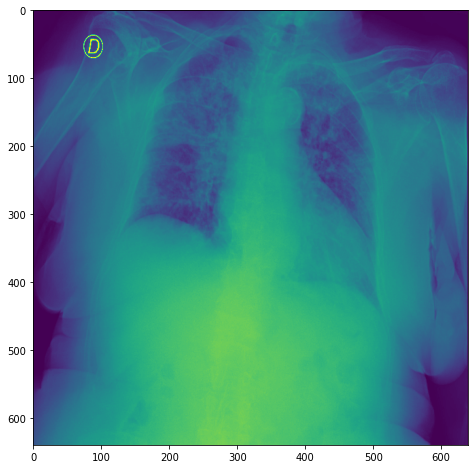

In [ ]:
visualize(train_df, 2)

In [ ]:
def dicom2array(path, voi_lut=True, fix_monochrome=True): # dicom
    dicom = pydicom.dcmread(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def normalize_image(image):
    image_max = image.max().item()
    image_min = image.min().item()
    image_norm = (image - image_min) / (image_max - image_min)
    return image_norm

In [ ]:
def make_labels(df, fold=0):
    directory = '/content/siim/labels'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    
    for idx, df in enumerate([train_df, valid_df]):
        if idx == 0: 
            sep_directory = os.path.join(directory, 'train')
            if not os.path.exists(sep_directory):
                os.makedirs(sep_directory)
        elif idx == 1:
            sep_directory = os.path.join(directory, 'val')
            if not os.path.exists(sep_directory):
                os.makedirs(sep_directory)
                
        df = df.sort_index()
        image_ids = df['ImageInstanceUID'].tolist()
        class_labels = df['Opacity'].tolist() # fix to 3 class
        # class_labels = (df['integer_label'] - 1).tolist()
        bboxes_iter = df[[f'box_{i}' for i in range(8)]].iterrows()
        
        for image_id, class_label, (bbox_idx, bbox) in zip(image_ids, class_labels, bboxes_iter):
            filename = f'{image_id}.txt'
            file_path = os.path.join(sep_directory, filename)
            bboxes = bbox.dropna().tolist()
            with open(file_path, 'w') as file:
                if np.isnan(np.sum(bboxes)):
                    file.write('')
                else:
                    for box in bboxes:
                        box = np.clip(0.0, 1.0, box)
                        file.write(f'{0} {box[0]} {box[1]} {box[2]} {box[3]}\n')
                                        # class x_center y_center width height

In [ ]:
def copy_images(copy_from, df, fold=0, image_size=config['image_size']):
    directory = '/content/siim/images'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    
    for idx, df in enumerate([train_df, valid_df]):
        if idx == 0: 
            sep_directory = os.path.join(directory, 'train')
            if not os.path.exists(sep_directory):
                os.makedirs(sep_directory)
        elif idx == 1:
            sep_directory = os.path.join(directory, 'val')
            if not os.path.exists(sep_directory):
                os.makedirs(sep_directory)
        
        df = df.sort_index()
        images_list = df['train_jpg'].tolist()
        for original_image_path in images_list:
            image_name = re.findall(f'{copy_from}/(.*).jpg', original_image_path)[0]
            target = os.path.join(sep_directory, f'{image_name}.jpg')
            shutil.copy(original_image_path, target)

In [ ]:
def make_yaml(train_path, val_path, num_classes, class_names):
#     yaml_list = []
#     train = dict(train=train_path)
#     val = dict(val=val_path)
#     nc = dict(nc=int(num_classes))
#     names = dict(names=class_names)
    
#     yaml_list.append(train)
#     yaml_list.append(val)
#     yaml_list.append(nc)
#     yaml_list.append(names)
    yaml_dict = dict(
        train=train_path,
        val=val_path,
        nc=int(num_classes),
        names=class_names
    )
    
    filename = r'/content/siim/siim_covid19.yaml'
    
    with open(filename, 'w') as file:
        doc = yaml.dump(yaml_dict, file)

In [ ]:
def make_train_val_info(df, train_path, val_path, fold=0):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    
    for idx, path in enumerate([train_path, val_path]):
        if idx == 0:
            with open(path, 'w') as file:
                images_list = glob('/content/siim/images/train/*')
                for image_path in images_list:
                    file.write(f'{image_path}\n')
        else:
            with open(path, 'w') as file:
                images_list = glob('/content/siim/images/val/*')
                for image_path in images_list:
                    file.write(f'{image_path}\n')

In [ ]:
def make_train_hyparam_yaml():
    default_hyp = '/content/yolov5/data/hyps/hyp.scratch-p6.yaml'
    custom_hyp = '/content/yolov5/data//hyps/hyp.custom.yaml'
    with open(default_hyp, 'r') as file:
        data = yaml.safe_load(file)
        # data['hsv_h'] = 0.0
        # data['hsv_v'] = 0.0
        data['scale'] = 0.5
        data['cls'] = 0.5
        data['obj'] = 1.0
        data['degrees'] = 10.0
        data['mixup'] = 0.4
        # data['shear'] = 5.0
        data['lr0'] = 0.001 # normal training lr

        # fine tuning on lower lr
        data['lr0'] = 0.0001
        data['lrf'] = 1
        with open(custom_hyp, 'w') as custom_file:
            new_data = yaml.dump(data, custom_file)

In [ ]:
def prepare_data(df, fold=0):
    if os.path.exists('/content/siim'):
        !rm -rf '/content/siim'
        print('[Deleted previous file]')
    make_labels(df, fold=fold)
    copy_images(TRAIN_JPG, df, fold=fold)
    
    train_path = '/content/siim/images/train'
    val_path = '/content/siim/images/val'
    num_classes = 1
    class_names = ['opacity']
    
    make_yaml(train_path, val_path, num_classes, class_names)
    make_train_hyparam_yaml()


In [ ]:
fold_num = 0

# folds_3_cls = folds_df[folds_df['integer_label'] > 0]
# prepare_data(folds_3_cls, fold=fold_num)
prepare_data(folds_df, fold=fold_num)

[Deleted previous file]


In [ ]:
# find matched labels and images
# total = 0
# for image in sorted(os.listdir('/content/siim/images/train')):
#     for label in sorted(os.listdir('/content/siim/labels/train')):
#         matched = (re.findall('(.*).png', image)[0]) == (re.findall('(.*).txt', label)[0])
#         if matched:
#             print(f'image: {image}, label: {label}, matched: {matched}')
#             total += 1
# print('total matched', total)

In [ ]:
cur = os.getcwd()
os.chdir('/content/yolov5')
!pip install -qr requirements.txt
# os.chdir(cur)

     |████████████████████████████████| 636 kB 4.8 MB/s 


In [ ]:
weights_string = [
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt ' +\
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f1_yolov5m6_neg_640px-best.pt ' +\
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f2_yolov5m6_neg_640px-best.pt ' +\
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f3_yolov5m6_neg_640px-best.pt ' +\
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f4_yolov5m6_neg_640px-best.pt'
]

weights_list = [
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt',
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f1_yolov5m6_neg_640px-best.pt',
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f2_yolov5m6_neg_640px-best.pt',
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f3_yolov5m6_neg_640px-best.pt',
                '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f4_yolov5m6_neg_640px-best.pt',
]

In [ ]:
model = 'yolov5m6'

In [ ]:
# os.environ["WANDB_RUN_GROUP"] = f'{model}_neg_{config["image_size"]}px-'+ wandb.util.generate_id()
os.environ["WANDB_RUN_GROUP"] = f'{model}_neg_{config["image_size"]}px-' + 'FT'
# os.environ["WANDB_RUN_GROUP"] = f'{model}_{config["image_size"]}px-' + '1ewbgmi3'

In [ ]:
# v5s : --cfg models/yolov5s.yaml --weights yolov5s.pt
# v5m : --cfg models/yolov5m.yaml --weights yolov5m.pt
# v5l : --cfg models/yolov5l.yaml --weights yolov5l.pt
# v5x : --cfg models/yolov5x.yaml --weights yolov5x.pt

In [ ]:
wandb.login(key="3b4a4f9e3a49edd10367fc27bad65a138866678d")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# !python /content/yolov5/train.py --cfg models/hub/{model}.yaml --weights {model}.pt --img {config['image_size']} --batch 16 --epochs 40 --cache --save_period 10 \
# --data /content/siim/siim_covid19.yaml --hyp /content/yolov5/data/hyps/hyp.custom.yaml --project siim-covid19-detection --name f{fold_num}_{model}_{config['image_size']}px 

# Fine tuning
!python /content/yolov5/train.py --cfg models/hub/{model}.yaml --weights {weights_list[fold_num]} --img {config['image_size']} --batch 16 --epochs 30 --cache --save_period 10 \
--data /content/siim/siim_covid19.yaml --hyp /content/yolov5/data/hyps/hyp.custom.yaml --project siim-covid19-detection --name f{fold_num}_{model}_{config['image_size']}px-FT

train: weights=/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt, cfg=models/hub/yolov5m6.yaml, data=/content/siim/siim_covid19.yaml, hyp=/content/yolov5/data/hyps/hyp.custom.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=siim-covid19-detection, entity=None, name=f0_yolov5m6_640px-FT, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=10, artifact_alias=latest, local_rank=-1, freeze=0
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-345-g2d99063 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: anchor_t=4.0, box=0.05, cls=0.5, cls_pw=1.0, copy_paste=0.0, degrees=10.0, fl_gamma=0.0, fliplr=0.5, flipud=

In [ ]:
# wandb.finish()

In [ ]:
!python /content/yolov5/val.py --weights {weights_list[fold_num]} --data /content/siim/siim_covid19.yaml --img 640 --augment --half --iou-thres 0.5
#--conf-thres {}

val: data=/content/siim/siim_covid19.yaml, weights=['/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=val, device=, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v5.0-345-g2d99063 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 396 layers, 35433624 parameters, 0 gradients, 51.3 GFLOPs
val: Scanning '/content/siim/labels/val.cache' images and labels... 1196 found, 0 missing, 342 empty, 0 corrupted: 100% 1196/1196 [00:00<00:00, 10976778.08it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 38/38 [01:58<00:00,  3.13s/it]
                 all       1196       1560      0.577      0.524      0.532      0.174
Speed: 0.3ms pre-process, 25.5ms inference

In [ ]:
!python /content/yolov5/val.py --weights /content/yolov5/siim-covid19-detection/f0_yolov5m6_640px-FT/weights/best.pt --data /content/siim/siim_covid19.yaml --img 640 --augment --half --iou-thres 0.5

val: data=/content/siim/siim_covid19.yaml, weights=['/content/yolov5/siim-covid19-detection/f0_yolov5m6_640px-FT/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=val, device=, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v5.0-345-g2d99063 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 396 layers, 35433624 parameters, 0 gradients, 51.3 GFLOPs
val: Scanning '/content/siim/labels/val.cache' images and labels... 1196 found, 0 missing, 342 empty, 0 corrupted: 100% 1196/1196 [00:00<00:00, 13029578.14it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 38/38 [01:58<00:00,  3.13s/it]
                 all       1196       1560      0.632      0.481      0.527      0.172
Speed: 0.1ms pre-process, 25.5ms inference, 5.6ms NMS per image at s

In [ ]:
# !python /content/yolov5/val.py --weights /content/yolov5/siim-covid19-detection/f0_yolov5m6_640px-FT/weights/best.pt --data /content/siim/siim_covid19.yaml --img 640 --augment --half --iou-thres 0.5`

In [ ]:
m6_weights_string = '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f1_yolov5m6_neg_640px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f2_yolov5m6_neg_640px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f3_yolov5m6_neg_640px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f4_yolov5m6_neg_640px-best.pt'

l6_weights_string = '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f0_yolov5l6_512px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f1_yolov5l6_512px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f2_yolov5l6_512px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f3_yolov5l6_512px-best.pt ' +\
                    '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f4_yolov5l6_512px-best.pt'

In [ ]:
!python /content/yolov5/val.py --weights {m6_weights_string} --data /content/siim/siim_covid19.yaml --img 640 --augment --half --iou-thres 0.5

val: data=/content/siim/siim_covid19.yaml, weights=['/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f0_yolov5m6_neg_640px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f1_yolov5m6_neg_640px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f2_yolov5m6_neg_640px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f3_yolov5m6_neg_640px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5m6_neg_640px/f4_yolov5m6_neg_640px-best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=val, device=, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v5.0-347-g4103ce9 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 396 layers, 35433624 parameters, 0 gradients, 51.3 G

In [ ]:
!python /content/yolov5/val.py --weights {l6_weights_string} --data /content/siim/siim_covid19.yaml --img 640 --augment --half --iou-thres 0.5

val: data=/content/siim/siim_covid19.yaml, weights=['/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f0_yolov5l6_512px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f1_yolov5l6_512px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f2_yolov5l6_512px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f3_yolov5l6_512px-best.pt', '/content/drive/MyDrive/kaggle/siim-covid19-detection/yolov5l6_512px/f4_yolov5l6_512px-best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, task=val, device=, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v5.0-347-g4103ce9 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 501 layers, 76610952 parameters, 0 gradients, 116.3 GFLOPs
Fusing layers... 
Model Summary: 

In [ ]:
!python /content/yolov5/val.py --weights {m6_weights_string} {l6_weights_string} --data /content/siim/siim_covid19.yaml --img 640 --augment --half --iou-thres 0.5